In [357]:
import pandas as pd
import requests
import numpy as np
import json
from datetime import datetime
import matplotlib.pyplot as plt
from itertools import islice
from os.path import exists

pd.set_option('display.max_colwidth', None)

In [883]:
class MyPortfolio:
    """
    Python ETL script for Friktion user portfolio data. 
    
    Currently supported Instruction Names: 
        - Deposit
        - CancelPendingDeposit
        - Withdrawal
        - CancelPendingWithdrawal
        - ClaimPendingWithdrawal
    """
    
    
    def __init__(self, 
                 date_start, 
                 date_end, 
                 ix_fname='friktion_ix.csv', 
                 deposit_fname='friktion_deposit.csv', 
                 deposit_cxl_fname='friktion_deposit_cxl.csv', 
                 withdraw_fname='friktion_withdraw.csv', 
                 withdraw_cxl_fname='friktion_withdraw_cancel.csv',
                 withdraw_claim_fname='friktion_claim_withdrawal.csv',
                 batch_size_days=14, 
                 batch_size_xfers=50
            ):
        """
        :ix_fname:              output csv for instructions
        :deposit_fname:         output csv for deposits
        :deposit_cxl_fname:     output csv for deposit cancels
        :withdraw_fname:        output csv for withdrawals
        :withdraw_cxl_fname:    output csv for withdrawal cancels
        :withdraw_claim_fname:    output csv for claiming pending withdrawal
        :batch_size_days:       batch size in days for query to keep query < 10k rows. Use bigger steps for larger data.
        :batch_size_transfers:  batch size transactions for query to keep query < 8kb 

        """
        self.volt_program = "VoLT1mJz1sbnxwq5Fv2SXjdVDgPXrb9tJyC8WpMDkSp"
        self.date_start = date_start
        self.date_end = date_end
        self.ix_fname = ix_fname
        self.deposit_fname = deposit_fname
        self.deposit_cxl_fname = deposit_cxl_fname
        self.withdraw_fname = withdraw_fname
        self.withdraw_cxl_fname = withdraw_cxl_fname
        self.withdraw_claim_fname = withdraw_claim_fname
        self.batch_size_days = batch_size_days
        self.batch_size_xfers = batch_size_xfers
        self.df_ix = []


    ########################################################################################################
    ####################################          Queries             ######################################
    ########################################################################################################
    
    
    @property
    def ix_query(self):
        return """
            query MyQuery {
              solana {
                instructions(
                  time: {between: ["%s", "%s"]}
                  success: {is: true}
                  programId: {is: "VoLT1mJz1sbnxwq5Fv2SXjdVDgPXrb9tJyC8WpMDkSp"}
                ) {
                  block {
                    timestamp {
                      iso8601
                    }
                  }
                  log {
                    consumed
                    instruction
                    logs
                  }
                  transaction {
                    signature
                    success
                    feePayer
                  }
                }
              }
            }
        """
        
        
    @property
    def xfer_query(self):
        return """
            query MyQuery {
              solana(network: solana) {
                transfers(
                  signature: {in: [%s]}
                ) {
                  instruction {
                    action {
                      name
                    }
                    callPath
                  }
                  amount(success: {is: true})
                  transaction {
                    signer
                    signature
                  }
                  block {
                    timestamp {
                      iso8601
                    }
                  }
                  currency {
                    name
                    address
                    symbol
                    decimals
                  }
                  sender {
                    address
                    mintAccount
                  }
                  receiver {
                    address
                    mintAccount
                  }
                }
              }
            }
        """
        
        
    ########################################################################################################
    ################################          Helper Functions             #################################
    ########################################################################################################
    
    
    @staticmethod
    def run_query(query):  # A simple function to use requests.post to make the API call.
        headers = {'X-API-KEY': 'BQYCaXaMZlqZrPCSQVsiJrKtxKRVcSe4'}
        request = requests.post('https://graphql.bitquery.io/', json={'query': query}, headers=headers)
        if request.status_code == 200:
            return request.json()
        else:
            print(request.reason)
            raise Exception('Query failed and return code is {}.{}'.format(request.status_code, query))
    
    
    @staticmethod
    def batch_iterable(iterable, n=1):
        """
        Takes in an iterable and returns an iterable of iterables with len==x
        """
        idxs = []
        l = len(iterable)
        for idx in range(0, l, n):
            idxs.append(iterable[idx:min(idx+n, l)])
        return idxs
        
        
    def format_txs_for_query(self, tx_signatures):
        """
        Batches a list of transactions into a list of string formatted transactions for querying. 
        Each of these strings contain (n=self.batch_size_xfers) unique transaction IDs.
        """
        batched_signatures = self.batch_iterable(tx_signatures, self.batch_size_xfers)
        
        def format_txs(x):
            return str(x)[1:-1].replace("\'", "\"").replace("\n", "")
        
        tx_strs = list(map(format_txs, batched_signatures))

        return tx_strs
    
    
    def get_existing_df(self, fname):
        # Create output file if doesn't exist
        if fname and exists(fname):
            return pd.read_csv(fname)
        else:
            return pd.DataFrame()
    
    ########################################################################################################
    ################################          Data Retrieval             ###################################
    ########################################################################################################
    
    
    def get_ix(self, date_start, date_end):
        """
        Runs graphql instruction query for one date range. 
        """
        query = self.ix_query % (date_start, date_end)
        print(datetime.now(), "retrieving instructions for {} to {}".format(date_start, date_end))
        result = self.run_query(query)
        
        # convert GraphQL json to pandas dataframe
        df = pd.json_normalize(result['data']['solana']['instructions'])
        print(datetime.now(), df.shape[0], "instructions retrieved")
        
        df = df.rename(
            columns={
                "block.timestamp.iso8601": "timestamp", 
                "log.consumed": "computeUnits", 
                "log.instruction": "instructionType", 
                "log.logs": "programLogs", 
                "transaction.signature": "txSignature", 
                "transaction.success": "txSuccess", 
                "transaction.feePayer": "txSigner"
            }
        )
        return df
    
    
    def get_ix_batch(self):
        """
        Batch the instruction retrieval. Save the shit Drop duplicates. 

        """
        
        df_ix = self.get_existing_df(self.ix_fname)
        
        # Batch the days up nice and good so the graphql API calls don't bitch
        dates_batched = pd.date_range(self.date_start, self.date_end, freq='7D')
        dates_batched = [str(x.isoformat()) for x in dates_batched.append(pd.DatetimeIndex([self.date_end]))]
        date_ranges = list(zip(dates_batched, dates_batched[1:]))
        
        xfers = []
        
        for date_range in date_ranges:
            assert len(date_range)==2
            data = self.get_ix(date_range[0], date_range[1])
            xfers.append(data)
            
        df_ix = pd.concat(xfers, ignore_index=False)
        df_ix.drop_duplicates().to_csv(self.ix_fname, index=False)
        print(datetime.now(), "final data size: ", df_ix.shape[0])
        self.df_ix = df_ix
    
        
    def get_batched_xfers(self, instructionType, fname):
        """
        Get all transfers corresponding to a specific instructionType from Graphql query. 
        Batch these queries up b/c the string sizes are too large (curse GraphQL for not supporting joins)
        
        :instructionType: String corresponding to the instruction type of each query. 
        :fname: Name of where the old df is stored
        
        """
        # assert self.df_ix, "Error: instructions get_ix_batch() must be called before xfers are scraped"
            
        temp = self.df_ix.query("instructionType=='%s'" % (instructionType))
        
        if temp.empty:
            print(datetime.now(), "instructionType was not found in the data... breaking")
            return
        
        tx_signatures = list(temp["txSignature"].unique())
        tx_strs = self.format_txs_for_query(tx_signatures)
        
        xfers = []
        
        for tx_str in tx_strs:
            query = self.xfer_query % (tx_str)
            result = self.run_query(query)
            df = pd.json_normalize(result['data']['solana']['transfers'])
            xfers.append(df)
            # print(datetime.now(), df.shape[0], "transfers scraped")

        df_xfer = pd.concat(xfers, ignore_index=False)
        df_xfer = df_xfer.rename(
            columns={
                "block.timestamp.iso8601": "timestamp", 
                "instruction.action.name": "instructionAction", 
                "instruction.callPath": "instructionOrder", 
                "transaction.signer": "userAddress", 
                "transaction.signature": "txSignature", 
                "currency.symbol": "currencySymbol", 
                "currency.name": "currencyName", 
                "receiver.address": "receiverAddress", 
                "sender.address": "senderAddress", 
                "currency.decimals": "currencyDecimals",
                "currency.address": "currencyAddress", 
            }
          )
        
        print(datetime.now(), df_xfer.shape[0], "transfers retrieved")

        df_old = self.get_existing_df(fname)
        df_final = df_old.append(df_xfer, ignore_index=True).sort_values("instructionOrder")
        return df_final
    
    
    #TODO: Get rid of duplicated code here
    def parse_deposits(self):
        instructionType = 'Deposit'
        df_deposit = self.get_batched_xfers(instructionType, self.deposit_fname)

        # Get rid of confusing wSOL entries
        df_deposit = df_deposit.query('currencyName != "Wrapped SOL"')

        # The deposit is always the last transfer in the transaction.
        df_deposit = df_deposit.query('instructionAction=="transfer"').groupby("txSignature").last().reset_index()
        
        df_deposit.drop_duplicates().to_csv(self.deposit_fname, index=False)
        print(datetime.now(), "Deposit data size: ", df_deposit.shape[0])
            
            
    def parse_withdrawal(self):
        instructionType = 'Withdraw'
        df_withdraw = self.get_batched_xfers(instructionType, self.withdraw_fname)
        
        # The deposit is always the burn transfer in the transaction.
        df_withdraw = df_withdraw.query('instructionAction=="burn"').groupby("txSignature").last().reset_index()
        
        df_withdraw.drop_duplicates().to_csv(self.withdraw_fname, index=False)
        print(datetime.now(), "Withdraw data size: ", df_withdraw.shape[0])        
        
        
    def parse_deposit_cancel(self):
        instructionType = 'CancelPendingDeposit'
        df_deposit_cxl = self.get_batched_xfers(instructionType, self.deposit_cxl_fname)
        
        # Get rid of confusing wSOL entries
        df_deposit_cxl = df_deposit_cxl.query('currencyName != "Wrapped SOL"')

        # The deposit is always the last transfer in the transaction.
        df_deposit_cxl = df_deposit_cxl.query('instructionAction=="transfer"').groupby("txSignature").last().reset_index()
        
        df_deposit_cxl.drop_duplicates().to_csv(self.deposit_cxl_fname, index=False)
        print(datetime.now(), "Cancel Deposit data size: ", df_deposit_cxl.shape[0])        
                
        
    def parse_withdrawal_cancel(self):
        instructionType = 'CancelPendingWithdrawal'
        df_withdraw_cxl = self.get_batched_xfers(instructionType, self.withdraw_cxl_fname)
        
        # Get rid of confusing wSOL entries
        df_withdraw_cxl = df_withdraw_cxl.query('currencyName != "Wrapped SOL"')

        # The deposit is always the last mintTo instruction.
        df_withdraw_cxl = df_withdraw_cxl.query('instructionAction=="mintTo"').groupby("txSignature").last().reset_index()
        
        df_withdraw_cxl.drop_duplicates().to_csv(self.withdraw_cxl_fname, index=False)
        print(datetime.now(), "Cancel Withdraw data size: ", df_withdraw_cxl.shape[0])  
        
        
    def parse_claim_withdrawal(self):
        instructionType = 'ClaimPendingWithdrawal'
        df_claim_withdraw = self.get_batched_xfers(instructionType, self.withdraw_claim_fname)
        
        # Get rid of confusing wSOL entries
        df_claim_withdraw = df_claim_withdraw.query('currencyName != "Wrapped SOL"')

        # The deposit is always the last transfer in the transaction.
        df_claim_withdraw = df_claim_withdraw.query('instructionAction=="transfer"').groupby("txSignature").last().reset_index()
        
        df_claim_withdraw.drop_duplicates().to_csv(self.withdraw_claim_fname, index=False)
        print(datetime.now(), "Claim Pending Withdraw data size: ", df_claim_withdraw.shape[0])  
        
        
        

In [884]:
date_start = "2021-12-16T00:00:00Z"
date_end = "2022-03-31T00:00:00Z"

In [885]:
x = MyPortfolio(date_start, date_end)

In [886]:
x.get_ix_batch()

2022-03-30 02:26:28.507464 retrieving instructions for 2021-12-16T00:00:00+00:00 to 2021-12-23T00:00:00+00:00
2022-03-30 02:26:36.095154 1706 instructions retrieved
2022-03-30 02:26:36.096554 retrieving instructions for 2021-12-23T00:00:00+00:00 to 2021-12-30T00:00:00+00:00
2022-03-30 02:26:42.011800 2604 instructions retrieved
2022-03-30 02:26:42.013725 retrieving instructions for 2021-12-30T00:00:00+00:00 to 2022-01-06T00:00:00+00:00
2022-03-30 02:26:51.165003 4377 instructions retrieved
2022-03-30 02:26:51.167466 retrieving instructions for 2022-01-06T00:00:00+00:00 to 2022-01-13T00:00:00+00:00
2022-03-30 02:27:00.600225 4014 instructions retrieved
2022-03-30 02:27:00.603483 retrieving instructions for 2022-01-13T00:00:00+00:00 to 2022-01-20T00:00:00+00:00
2022-03-30 02:27:12.367887 6022 instructions retrieved
2022-03-30 02:27:12.371374 retrieving instructions for 2022-01-20T00:00:00+00:00 to 2022-01-27T00:00:00+00:00
2022-03-30 02:27:21.580970 5413 instructions retrieved
2022-03-30

In [899]:
x.parse_claim_withdrawal()

2022-03-30 02:37:16.670816 3870 transfers retrieved
2022-03-30 02:37:16.756948 Claim Pending Withdraw data size:  1322


In [879]:
x.parse_withdrawal_cancel()

2022-03-30 02:14:04.479336 123 transfers retrieved
2022-03-30 02:14:04.499429 Cancel Withdraw data size:  123


In [880]:
x.parse_deposit_cancel()

2022-03-30 02:14:13.904903 638 transfers retrieved
2022-03-30 02:14:13.925068 Cancel Deposit data size:  227


In [881]:
x.parse_deposits()

2022-03-30 02:18:18.958431 18661 transfers retrieved
2022-03-30 02:18:19.071319 Deposit data size:  4767


In [882]:
x.parse_withdrawal()

2022-03-30 02:19:32.392767 7106 transfers retrieved
2022-03-30 02:19:32.435373 Withdraw data size:  1817


In [910]:
ix = pd.read_csv("friktion_ix.csv")

In [888]:
withdrawals = pd.read_csv("friktion_withdraw.csv")

In [904]:
claim_withdrawals = pd.read_csv("friktion_claim_withdrawal.csv")

In [909]:
set(withdrawals.userAddress).difference(set(claim_withdrawals.userAddress))

{'12o2DKzPyR9pUCdfeUjPHQATgc8oNMVfozdz5FcoCY62',
 '1GizX3WoSesTdyY8jxDASVFtF3sTMz3oeTckKATKwQv',
 '24W8AmuTBN73JSr5vRU8PKySnxnA6FkSAwCy7WsKN3FH',
 '28gBLRWqLi4owczitNjQn3Jm5PZvAvM2pQ84FTy6WQJd',
 '292NUgqRgGkYoc9UCJhBHKKhwoDaGTAuTi5yfhqHHq4A',
 '292kuKpd2aKqqU8feN3EeDvQFEfMjakD2EtWg6NjXwSX',
 '29mPZLHh7wKE2aFsnWT6bjfEJb2unV8ooxoMZnwaK7bk',
 '2AVd9avykEseAZVE8dKGnDHsbxFQByii1NHqwB1Vqxi6',
 '2CSEjyDtAtgCjTKyXHZyfUVe7EERtL7rjYjJSgcBPYLf',
 '2EfiRdR97jnSknN7KiVwGqXATvuSgGiTypMdiwXxBbxh',
 '2FTBkiF8fptxMoeWMxBjvbwcv46Te24E4uPL92Qze6Fy',
 '2Lm8Ps6rxkXoxYLMDFrieYeNUnqy5hFhsZMKUzx2VMYc',
 '2LvCaow2GYwP6Fhj1ueNWwETHGwXzyJZ7kRdp7SHbXDq',
 '2PQtPdeAo529F4yPWLd7pbGN5mBKqXJJ4d9i9BaB1zUC',
 '2PWE862wAiRFte7GZAQXCManXiaTtCnZgdJrJxNEygTj',
 '2UormwnGJWq7V3b649QL6mxYd1TpJmqnr86MuFd5AfdN',
 '2Zmabu6wfo4T93dyk1Z44y14H914GJCDM84co8rs7Sve',
 '2a1mgH9HKKfr75rVjyhj4KrYw8u6CKeXn25xL2PQ4G33',
 '2ahZRoF2QLNe4aTC9LM6TGA3ufDDMPhaPBDDeNPg2pFT',
 '2ceteeHWhwdhENHfhGTLfimc3FAGRpPbMuCafrZGxYri',
 '2cgrNDTMhgjdvUaHH1R

In [914]:
ix.txSigner.unique().shape

(12057,)

In [919]:
deposits = pd.read_csv("friktion_deposit.csv")

In [925]:
deposits.loc[deposits.userAddress=="3e4Jt7gxy6uFUBjVKqFUbPsHaB6vCC7KFKtgvzCRSpprMcJVdJR9kBD6HAwAyA5NPfBbY329w8pyX5Xoq3WLe4cL"]

,txSignature,amount,instructionAction,instructionOrder,userAddress,timestamp,currencyName,currencyAddress,currencySymbol,currencyDecimals,senderAddress,sender.mintAccount,receiverAddress,receiver.mintAccount


In [915]:
ix.loc[ix.txSigner=="2FTBkiF8fptxMoeWMxBjvbwcv46Te24E4uPL92Qze6Fy"]

,timestamp,computeUnits,instructionType,programLogs,txSignature,txSuccess,txSigner
7713,2022-01-04T04:06:33Z,127490,NaN,Program VoLT1mJz1sbnxwq5Fv2SXjdVDgPXrb9tJyC8WpMDkSp invoke [1];Program VoLT1mJz1sbnxwq5Fv2SXjdVDgPXrb9tJyC8WpMDkSp consumed 127490 of 200000 compute units;Program VoLT1mJz1sbnxwq5Fv2SXjdVDgPXrb9tJyC8WpMDkSp success,fKTrvCcJrYNuz3DkP4mCw7PJEUj71ctLFwmDK1Xvtm5xGEdxhUnsqGfW4cQaFSqgKZCXRQ5uZLnLrP4kmpoJqXM,True,2FTBkiF8fptxMoeWMxBjvbwcv46Te24E4uPL92Qze6Fy
7715,2022-01-04T04:10:11Z,107143,NaN,Program VoLT1mJz1sbnxwq5Fv2SXjdVDgPXrb9tJyC8WpMDkSp invoke [1];Program VoLT1mJz1sbnxwq5Fv2SXjdVDgPXrb9tJyC8WpMDkSp consumed 107143 of 200000 compute units;Program VoLT1mJz1sbnxwq5Fv2SXjdVDgPXrb9tJyC8WpMDkSp success,3HsdAzqaM3DBmXeqaWy5KbymuQ4EzFeEsPyRaEHygUdgMXF7PvdpCdQEGLgPob5E9xmzQUamdY9SN5jHqKi6wbQf,True,2FTBkiF8fptxMoeWMxBjvbwcv46Te24E4uPL92Qze6Fy
7716,2022-01-04T04:10:29Z,90412,NaN,Program VoLT1mJz1sbnxwq5Fv2SXjdVDgPXrb9tJyC8WpMDkSp invoke [1];Program VoLT1mJz1sbnxwq5Fv2SXjdVDgPXrb9tJyC8WpMDkSp consumed 90412 of 200000 compute units;Program VoLT1mJz1sbnxwq5Fv2SXjdVDgPXrb9tJyC8WpMDkSp success,3e4Jt7gxy6uFUBjVKqFUbPsHaB6vCC7KFKtgvzCRSpprMcJVdJR9kBD6HAwAyA5NPfBbY329w8pyX5Xoq3WLe4cL,True,2FTBkiF8fptxMoeWMxBjvbwcv46Te24E4uPL92Qze6Fy
7718,2022-01-04T04:12:25Z,96826,NaN,Program VoLT1mJz1sbnxwq5Fv2SXjdVDgPXrb9tJyC8WpMDkSp invoke [1];Program VoLT1mJz1sbnxwq5Fv2SXjdVDgPXrb9tJyC8WpMDkSp consumed 96826 of 200000 compute units;Program VoLT1mJz1sbnxwq5Fv2SXjdVDgPXrb9tJyC8WpMDkSp success,5JcGgwF1XQUAX4AitB41nWSoCtiKWeVjBvynEQKheou9Au3JB16tugFvCTmzyixcsCPj26cATzyGwj5uLpAu1QA,True,2FTBkiF8fptxMoeWMxBjvbwcv46Te24E4uPL92Qze6Fy
7719,2022-01-04T04:13:46Z,97964,NaN,Program VoLT1mJz1sbnxwq5Fv2SXjdVDgPXrb9tJyC8WpMDkSp invoke [1];Program VoLT1mJz1sbnxwq5Fv2SXjdVDgPXrb9tJyC8WpMDkSp consumed 97964 of 200000 compute units;Program VoLT1mJz1sbnxwq5Fv2SXjdVDgPXrb9tJyC8WpMDkSp success,41nBDZ3jo2tpfLUp6GdXVZNS4M5VrJGJGJY6296wPmP4Pn1EP7rWjGMQcwCdHs1ZcRonJoqST2F5bHir3KHDMgPs,True,2FTBkiF8fptxMoeWMxBjvbwcv46Te24E4uPL92Qze6Fy
53995,2022-03-22T13:11:32Z,51953,ClaimPending,Program VoLT1mJz1sbnxwq5Fv2SXjdVDgPXrb9tJyC8WpMDkSp invoke [1];Program log: Instruction: ClaimPending;Program log: validating ClaimPending context;Program log: claim_pending deposit...;Program log: transferring w/ seeds 16961 tokens from 5ctYsrvRvEeywdcA71SmKPqUnzkyAXx8uD9vQjyrG9Uz to Deqqt9SCwyeNeS8y6x4RYjXQ1xbWufstWX6pMortvjJg;Program VoLT1mJz1sbnxwq5Fv2SXjdVDgPXrb9tJyC8WpMDkSp consumed 51953 of 200000 compute units;Program VoLT1mJz1sbnxwq5Fv2SXjdVDgPXrb9tJyC8WpMDkSp success,5W7ThQ6s19BfnDvth2ca1cdAmei2mwmYCTxwX43hQkfXrEnsWE7K8QW7DGsh3uDraJZ6rBtSz8ZdZpAy8QXHkPdJ,True,2FTBkiF8fptxMoeWMxBjvbwcv46Te24E4uPL92Qze6Fy
53996,2022-03-22T13:11:32Z,68981,Withdraw,Program VoLT1mJz1sbnxwq5Fv2SXjdVDgPXrb9tJyC8WpMDkSp invoke [1];Program log: Instruction: Withdraw;Program VoLT1mJz1sbnxwq5Fv2SXjdVDgPXrb9tJyC8WpMDkSp consumed 68981 of 200000 compute units;Program VoLT1mJz1sbnxwq5Fv2SXjdVDgPXrb9tJyC8WpMDkSp success,5W7ThQ6s19BfnDvth2ca1cdAmei2mwmYCTxwX43hQkfXrEnsWE7K8QW7DGsh3uDraJZ6rBtSz8ZdZpAy8QXHkPdJ,True,2FTBkiF8fptxMoeWMxBjvbwcv46Te24E4uPL92Qze6Fy
53997,2022-03-22T13:11:58Z,52038,ClaimPending,Program VoLT1mJz1sbnxwq5Fv2SXjdVDgPXrb9tJyC8WpMDkSp invoke [1];Program log: Instruction: ClaimPending;Program log: validating ClaimPending context;Program log: claim_pending deposit...;Program log: transferring w/ seeds 17933895 tokens from EXd2BMy69mGC7RNnsBLNYZudQVNGkfF7eFUCFbfehyww to 8d2VKtcQsa81Tv5B1ywWiw8dPmM2HnzBxBt3zUUtjpuQ;Program VoLT1mJz1sbnxwq5Fv2SXjdVDgPXrb9tJyC8WpMDkSp consumed 52038 of 200000 compute units;Program VoLT1mJz1sbnxwq5Fv2SXjdVDgPXrb9tJyC8WpMDkSp success,2NBX4WbjKpQEUyqcAsq2HejknbJQots3yR5KWkE2CeS9vEkowRgsWf4K4aBCBJ1GjCojjXWTuaBDLdeu5m6H3FjZ,True,2FTBkiF8fptxMoeWMxBjvbwcv46Te24E4uPL92Qze6Fy
53998,2022-03-22T13:11:58Z,71981,Withdraw,Program VoLT1mJz1sbnxwq5Fv2SXjdVDgPXrb9tJyC8WpMDkSp invoke [1];Program log: Instruction: Withdraw;Program VoLT1mJz1sbnxwq5Fv2SXjdVDgPXrb9tJyC8WpMDkSp consumed 71

<AxesSubplot:xlabel='timestamp'>

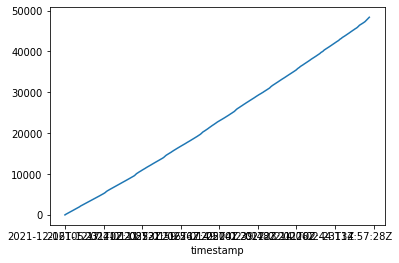

In [935]:
ix.loc[ix.instructionType.isna()].groupby("timestamp").computeUnits.count().cumsum().plot()

(array([-1000.,     0.,  1000.,  2000.,  3000.,  4000.,  5000.]),
 [Text(-1000.0, 0, '2022-03-29T19:10:11Z'),
  Text(0.0, 0, '2022-03-03T08:20:48Z'),
  Text(1000.0, 0, '2022-03-14T08:44:53Z'),
  Text(2000.0, 0, '2022-03-21T04:52:45Z'),
  Text(3000.0, 0, '2022-03-26T05:45:59Z'),
  Text(4000.0, 0, '2022-03-29T22:09:32Z'),
  Text(5000.0, 0, '')])

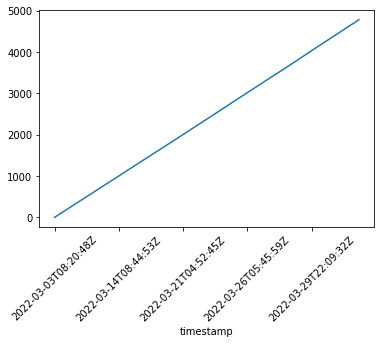

In [937]:
ix.loc[ix.instructionType=="Deposit"].groupby("timestamp").computeUnits.count().cumsum().plot()
plt.xticks(rotation=45)

(array([-250.,    0.,  250.,  500.,  750., 1000., 1250., 1500., 1750.,
        2000.]),
 [Text(-250.0, 0, '2022-03-27T06:34:39Z'),
  Text(0.0, 0, '2022-03-05T21:52:16Z'),
  Text(250.0, 0, '2022-03-10T22:27:04Z'),
  Text(500.0, 0, '2022-03-15T02:04:17Z'),
  Text(750.0, 0, '2022-03-19T02:30:17Z'),
  Text(1000.0, 0, '2022-03-22T21:42:25Z'),
  Text(1250.0, 0, '2022-03-24T19:28:47Z'),
  Text(1500.0, 0, '2022-03-26T10:01:57Z'),
  Text(1750.0, 0, '2022-03-29T12:14:40Z'),
  Text(2000.0, 0, '')])

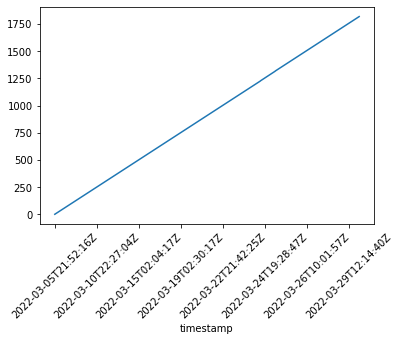

In [938]:
ix.loc[ix.instructionType=="Withdraw"].groupby("timestamp").computeUnits.count().cumsum().plot()
plt.xticks(rotation=45)

(array([-250.,    0.,  250.,  500.,  750., 1000., 1250., 1500., 1750.,
        2000., 2250.]),
 [Text(-250.0, 0, '2022-03-27T09:08:29Z'),
  Text(0.0, 0, '2022-03-03T08:48:03Z'),
  Text(250.0, 0, '2022-03-10T08:00:34Z'),
  Text(500.0, 0, '2022-03-13T12:42:05Z'),
  Text(750.0, 0, '2022-03-17T21:18:43Z'),
  Text(1000.0, 0, '2022-03-20T02:26:04Z'),
  Text(1250.0, 0, '2022-03-23T10:28:44Z'),
  Text(1500.0, 0, '2022-03-25T01:45:16Z'),
  Text(1750.0, 0, '2022-03-27T08:42:47Z'),
  Text(2000.0, 0, '2022-03-30T01:56:25Z'),
  Text(2250.0, 0, '')])

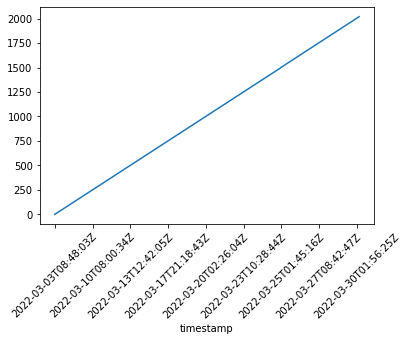

In [939]:
ix.loc[ix.instructionType=="ClaimPending"].groupby("timestamp").computeUnits.count().cumsum().plot()
plt.xticks(rotation=45)

In [ ]:
ix.

In [929]:
ix.shape

(59549, 7)

In [932]:
ix.loc[ix.txSignature=="3e4Jt7gxy6uFUBjVKqFUbPsHaB6vCC7KFKtgvzCRSpprMcJVdJR9kBD6HAwAyA5NPfBbY329w8pyX5Xoq3WLe4cL"]

,timestamp,computeUnits,instructionType,programLogs,txSignature,txSuccess,txSigner
7716,2022-01-04T04:10:29Z,90412,NaN,Program VoLT1mJz1sbnxwq5Fv2SXjdVDgPXrb9tJyC8WpMDkSp invoke [1];Program VoLT1mJz1sbnxwq5Fv2SXjdVDgPXrb9tJyC8WpMDkSp consumed 90412 of 200000 compute units;Program VoLT1mJz1sbnxwq5Fv2SXjdVDgPXrb9tJyC8WpMDkSp success,3e4Jt7gxy6uFUBjVKqFUbPsHaB6vCC7KFKtgvzCRSpprMcJVdJR9kBD6HAwAyA5NPfBbY329w8pyX5Xoq3WLe4cL,True,2FTBkiF8fptxMoeWMxBjvbwcv46Te24E4uPL92Qze6Fy
